In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


dataset_dir = "/content/drive/MyDrive/Projdsnew/augmented_ds"
categories = ["0", "25", "50", "75", "100"]


img_size = (224, 224)  # ResNet50 expects 224x224 images
batch_size = 32
epochs = 20

# Creating a list of all image paths and their corresponding labels
image_paths = []
labels = []

for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        image_paths.append(img_path)
        labels.append(category)

# Converting labels to integers
label_to_int = {category: i for i, category in enumerate(categories)}
labels = [label_to_int[label] for label in labels]

# Splitting the dataset into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet50
    return image, label

# Creating TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Loading ResNet50 with pre-trained weights (excluding the top classification layer)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freezing the base model
base_model.trainable = False

# Adding custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)  # 5 output classes

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

# Saving the model
model.save("resnet50_shrimp_feed_model.h5")
print("Model saved as resnet50_shrimp_feed_model.h5")

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 8s/step - accuracy: 0.2926 - loss: 2.7165 - val_accuracy: 0.6000 - val_loss: 0.9150
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 8s/step - accuracy: 0.6663 - loss: 0.8418 - val_accuracy: 0.7600 - val_loss: 0.7242
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.7814 - loss: 0.5551 - val_accuracy: 0.8133 - val_loss: 0.5608
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.8821 - loss: 0.3071 - val_accuracy: 0.8133 - val_loss: 0.5408
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9157 - loss: 0.2532 - val_accuracy: 0.8667 - val_loss: 0.5551
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.9183 - loss: 0.2657 - val_accuracy: 0.8400 - val_loss: 0.5307
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9186 - loss: 0.2053 - val_accuracy: 0.8533 - val_loss: 0.5219
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.

Model saved as resnet50_shrimp_feed_model.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9248 - loss: 0.1695
Test Accuracy: 92.00%


[0.38285714387893677, 0.6600000262260437, 0.8028571605682373, 0.8657143115997314, 0.9228571653366089, 0.9171428680419922, 0.9228571653366089, 0.9371428489685059, 0.9714285731315613, 0.9685714244842529, 0.9599999785423279, 0.954285740852356, 0.9685714244842529, 0.9742857217788696, 0.9742857217788696, 0.9800000190734863, 0.977142870426178, 0.9971428513526917, 0.9800000190734863, 0.9971428513526917]
[0.6000000238418579, 0.7599999904632568, 0.8133333325386047, 0.8133333325386047, 0.8666666746139526, 0.8399999737739563, 0.8533333539962769, 0.8399999737739563, 0.8533333539962769, 0.8533333539962769, 0.8533333539962769, 0.8399999737739563, 0.8266666531562805, 0.8133333325386047, 0.8399999737739563, 0.8399999737739563, 0.8533333539962769, 0.8266666531562805, 0.8533333539962769, 0.8533333539962769]


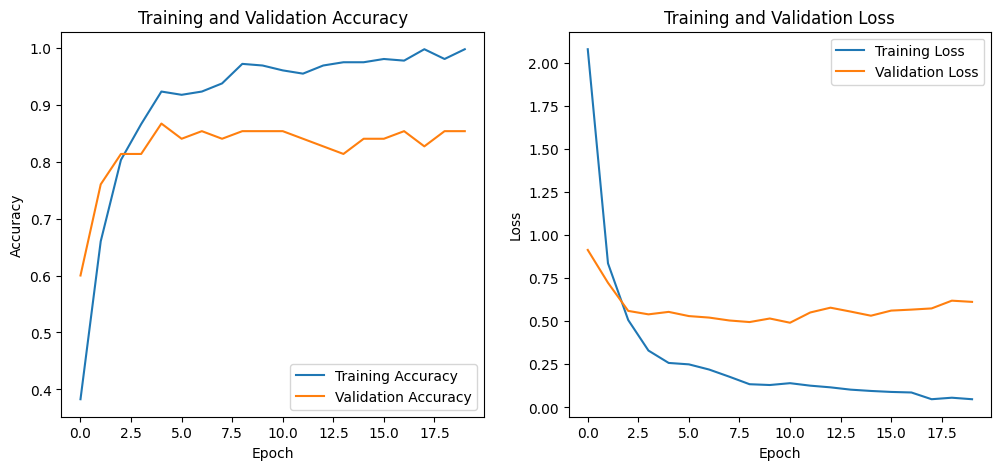

In [8]:
import matplotlib.pyplot as plt


training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


training_loss = history.history['loss']
validation_loss = history.history['val_loss']
print(training_accuracy)
print(validation_accuracy)
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:

final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]


print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 99.71%
Final Validation Accuracy: 85.33%


In [11]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, average_precision_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
model = tf.keras.models.load_model("/content/resnet50_shrimp_feed_model.h5")


dataset_dir = "/content/drive/MyDrive/Projdsnew/augmented_ds"
categories = ["0", "25", "50", "75", "100"]
img_size = (224, 224)  # ResNet50 expects 224x224 images
batch_size = 32


image_paths = []
labels = []

for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        image_paths.append(img_path)
        labels.append(category)


label_to_int = {category: i for i, category in enumerate(categories)}
labels = [label_to_int[label] for label in labels]


X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess for ResNet50
    return image, label


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)


print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=categories))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))





y_true = np.concatenate([y.numpy() for _, y in test_dataset])




f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"Macro F1 Score: {f1:.4f}")

y_true_onehot = label_binarize(y_true, classes=range(len(categories)))



ap_scores = []
for i in range(len(categories)):
    ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
    ap_scores.append(ap)
    print(f"AP for class {categories[i]}%: {ap:.4f}")


mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP): {mAP:.4f}")


precision_per_class = precision_score(y_true, y_pred_classes, average=None)
recall_per_class = recall_score(y_true, y_pred_classes, average=None)
f1_per_class = f1_score(y_true, y_pred_classes, average=None)


print("{:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1-score'))
print("-" * 40)
for i, class_name in enumerate(categories):
    print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        f"{class_name}%",
        precision_per_class[i],
        recall_per_class[i],
        f1_per_class[i]
    ))


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9248 - loss: 0.1695
Test Accuracy: 92.00%
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
          25       1.00      1.00      1.00        13
          50       0.86      0.60      0.71        10
          75       0.76      0.93      0.84        14
         100       0.94      0.94      0.94        18

    accuracy                           0.92        75
   macro avg       0.91      0.89      0.90        75
weighted avg       0.92      0.92      0.92        75

Confusion Matrix:
[[20  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0  6  3  1]
 [ 0  0  1 13  0]
 [ 0  0  0  1 17]]
Macro F1 Score: 0.8978
AP for class 0%: 1.0000
AP for class 25%: 1.0000
AP for class 50%: 0.8629
AP for class 75%: 0.9537
AP for class 100%: 0.9796

Mean Average Precision (mAP): 0.9592
Class      Precision  Recall     F1-score  
-------------------

In [12]:
from google.colab import files
files.download('resnet50_shrimp_feed_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import os
import shutil


test_split_dir = "/content/drive/MyDrive/Projdsnew/new_test_split"



os.makedirs(test_split_dir, exist_ok=True)


for image_path in X_test:

    image_name = os.path.basename(image_path)


    category = os.path.basename(os.path.dirname(image_path))


    category_dir = os.path.join(test_split_dir, category)
    os.makedirs(category_dir, exist_ok=True)


    shutil.copy(image_path, os.path.join(category_dir, image_name))

print(f"Test images saved to: {test_split_dir}")

Test images saved to: /content/drive/MyDrive/Projdsnew/new_test_split


Enter image path: /content/drive/MyDrive/Projdsnew/new_test_split/100/IMG_20241228_103005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[9.3512654e-08 1.9344892e-08 2.5391539e-05 8.3013289e-03 9.9167317e-01]]


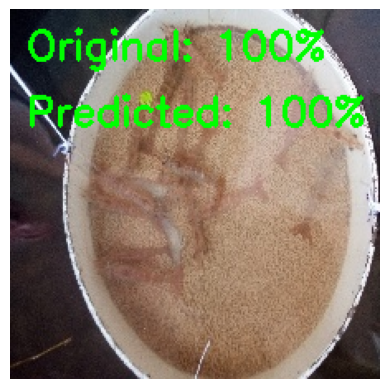

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


model = tf.keras.models.load_model("/content/resnet50_shrimp_feed_model.h5")


categories = ["0", "25", "50", "75", "100"]

# Function to preprocess the image for ResNet50
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess for ResNet50
    return image

# Function to predict and annotate the image
def predict_and_annotate(image_path, true_label):
    # Preprocess the image
    image = preprocess_image(image_path)
    image_np = image.numpy()

    # Predict the class
    prediction = model.predict(tf.expand_dims(image, axis=0))
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = categories[predicted_class]

    # Convert image back to original format for display
    image_display = cv2.imread(image_path)
    image_display = cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB)

    # Add text to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    font_thickness = 2
    text_color = (0, 255, 0)  # Green color

    # Original class label
    cv2.putText(image_display, f"Original: {true_label}%", (10, 30), font, font_scale, text_color, font_thickness)

    # Predicted class label
    cv2.putText(image_display, f"Predicted: {predicted_label}%", (10, 70), font, font_scale, text_color, font_thickness)

    return image_display


test_image_path = input("Enter image path: ")
true_label = "100"

# Generate annotated image
annotated_image = predict_and_annotate(test_image_path, true_label)

# Display the annotated image
plt.imshow(annotated_image)
plt.axis("off")
plt.show()